- https://github.com/facebookresearch/faiss/issues/2486
- https://gist.github.com/mdouze/b0a65aba70a64b00d6425b0e268a4c80

In [27]:
import numpy as np
import faiss
from matplotlib import pyplot

In [28]:
# create an inverted index
nlist = 1024
m = 8
k = 5
d = 64
coarse_quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(coarse_quantizer, d, nlist, m, 8)

In [29]:
# fill it in
xb = faiss.rand((10000, d), 1234)
index.train(xb)
index.add(xb)

WARNING clustering 10000 points to 1024 centroids: please provide at least 39936 training points


In [30]:
# if there is a pre-transform, you can also use
# invlists = faiss.extract_index_ivf(index).invlists
invlists = index.invlists

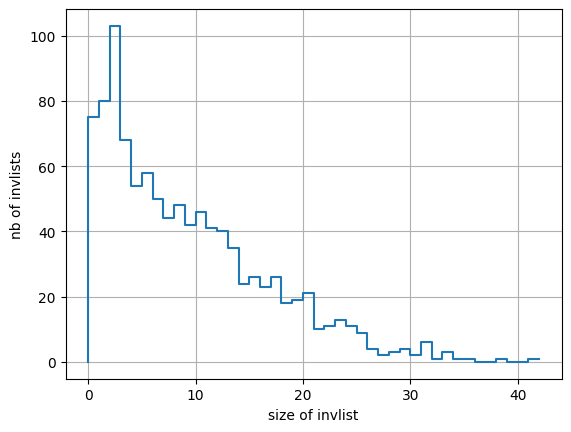

In [31]:
# invlist sizes histogram
bc = np.bincount([invlists.list_size(l) for l in range(invlists.nlist)])
pyplot.step(np.arange(bc.size), bc)
pyplot.xlabel("size of invlist")
pyplot.ylabel("nb of invlists")
pyplot.grid()

In [45]:
def get_invlist(invlists, l):
    """returns the inverted lists content as a pair of (list_ids, list_codes).
    The codes are reshaped to a proper size
    """
    invlists = faiss.downcast_InvertedLists(invlists)
    ls = invlists.list_size(l)
    list_ids = np.zeros(ls, dtype="int64")
    ids = codes = None
    try:
        ids = invlists.get_ids(l)
        if ls > 0:
            faiss.memcpy(faiss.swig_ptr(list_ids), ids, list_ids.nbytes)
        codes = invlists.get_codes(l)
        if invlists.code_size != faiss.InvertedLists.INVALID_CODE_SIZE:
            list_codes = np.zeros((ls, invlists.code_size), dtype="uint8")
        else:
            # it's a BlockInvertedLists
            npb = invlists.n_per_block
            bs = invlists.block_size
            ls_round = (ls + npb - 1) // npb
            list_codes = np.zeros((ls_round, bs // npb, npb), dtype="uint8")
        if ls > 0:
            faiss.memcpy(faiss.swig_ptr(list_codes), codes, list_codes.nbytes)
    finally:
        if ids is not None:
            invlists.release_ids(l, ids)
        if codes is not None:
            invlists.release_codes(l, codes)
    return list_ids, list_codes

In [46]:
invlists.get_ids(124)

<Swig Object of type 'long *' at 0x7f92082f7c00>

In [47]:
# get content of inverted list #123
list_ids, list_codes = get_invlist(invlists, 124)

In [48]:
# vector ids in the list
list_ids

array([ 375,  764, 1691, 1736, 2281, 2532, 2573, 2758, 3711, 3791, 6206,
       7364, 8009, 8828, 8849, 8865, 8988])

In [52]:
# check that vectors 375 and 764 are indeed quantized to list 124
coarse_quantizer.assign(xb[[375]], 1)

array([[124]])

In [51]:
invlists.code_size

8

In [50]:
# PQ codes stored in the inverted lists
list_codes.reshape(-1, invlists.code_size)

array([[135,  86, 175, 122, 143, 106,  69, 250],
       [ 22, 168, 238, 229, 218,  24,  93, 209],
       [226,  69,  61,  81, 235,  71, 218, 237],
       [130, 201,  27,  48,   8, 167, 247, 104],
       [ 53, 234, 190,   5,  21, 126,  54,  64],
       [124, 130,  34, 124, 205, 124, 124,  54],
       [ 92, 137, 123, 105, 152, 116,  26,  32],
       [100, 118, 163, 109, 211, 130, 109, 210],
       [ 32, 223,  59,  14, 183, 243, 186, 154],
       [160, 250, 189, 171,  21,  82, 232, 251],
       [ 98, 230,  85, 116,  85, 231, 139,   1],
       [ 42,  58,  54,  51,  13, 217,  23, 217],
       [240, 155,  77, 147,  29, 216,  53, 103],
       [150, 163,  70,  80, 187,  14, 202, 237],
       [ 84,  60, 164,  76, 107,  48, 180,   0],
       [ 58,  24,   5, 216, 136,   3,  74, 123],
       [ 54, 196,  31, 126, 195,  38,  63, 148]], dtype=uint8)

In [55]:
numbers = []
for i in range(len(xb)):
    num = coarse_quantizer.assign(xb[[i]], 1)
    numbers.append(num[0][0])
    # print(num)
max(numbers)

np.int64(1023)

In [ ]:
xb